In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from utils import *

np.random.seed(1)

### Fruchterman Reingold

<IPython.core.display.Javascript object>


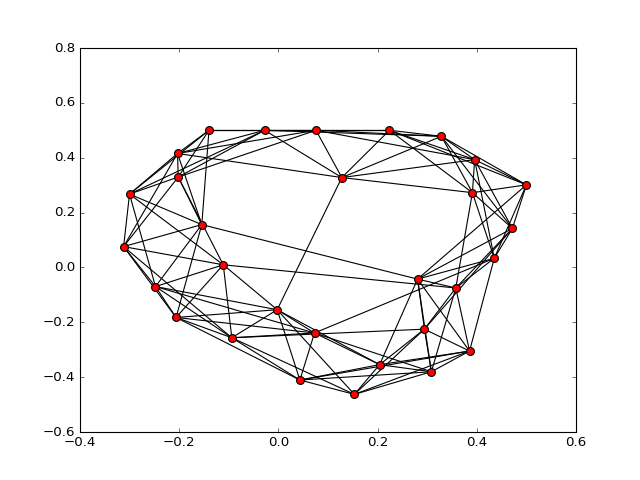

In [10]:
class FruchtermanReingold:
    '''
    T.M. Fruchterman, E.M. Reingold, Graph drawing by force-directed placement,
    Softw.: Pract. Exp. 21 (11) (1991) 1129–1164.
    '''
    
    def __init__(self, G, width=1.0, length=1.0, temperature=None, iterations=100):
        self.G = G
        self.M = nx.to_scipy_sparse_matrix(G, dtype='f')
        self.N_nodes = self.M.shape[0]

        self.pos = np.random.random((self.N_nodes, 2))
        
        self.width = float(width)
        self.length = float(length)
        self.area = self.width * self.length
        self.k = np.sqrt(self.area / self.N_nodes)

        self.temperature = temperature if temperature else self.width / 10

    def run(self, iterations=100):
        assert iterations >= 1
        assert type(iterations) is int
        
        t_curr = self.temperature
        dt = self.temperature / iterations
        
        for _ in range(iterations):
            # convert (x, y) positions to x+yj complex value
            z = np.array([complex(p[0], p[1]) for p in self.pos])

            delta = z[..., np.newaxis] - z  # pairwise Δx and Δy
            distance = abs(delta)  # pairwise distance
            distance[distance == 0] = 1  # for division convenience
            
            # all nodes exert a repulsive force on one another
            repulsion = self.k**2 * delta / distance**2
            
            # neighbor nodes exert an attractive force on one another
            attraction = -1.0 * distance * delta / self.k
            attraction = attraction * self.M.toarray()
            
            # sum the complex-valued displacement 'vectors' acting on each node
            # then make them real valued
            disp = np.sum(repulsion + attraction, axis=1)
            disp = np.array([np.real(disp), np.imag(disp)]).T

            # normalize displacement distances
            disp_dist, disp = normalize(disp)
            
            # move nodes, with temperature damping (simulated annealing)
            self.pos = self.pos + disp * np.minimum(disp_dist, t_curr)[:, np.newaxis]
            
            # ensure that the nodes remain within the box's area
            self.pos[:, 0] = np.minimum(self.width / 2, np.maximum(-1 * self.width / 2, self.pos[:, 0]))
            self.pos[:, 1] = np.minimum(self.length / 2, np.maximum(-1 * self.length / 2, self.pos[:, 1]))
            
            # cool off a bit, so later iterations produce less movement
            t_curr -= dt
            
    def display(self):
        display_plot(self.G, dict(zip(G.nodes(), self.pos)))

np.random.seed(1)

G = nx.watts_strogatz_graph(30, 8, 0.05, seed=81)

graph = FruchtermanReingold(G, width=1, length=1)
graph.run(100)
graph.display()
